# Cell Size Distribution of Microbial Communities

In [4]:
import matplotlib.pyplot as p
import numpy as np
from numpy import random
init_printing() # for pretty-printing equations etc

### Basic Lotka-Volterra model for multiple species

The adapted equation of the Lotka-Volterra model is here:<br>
<br>
$\frac{dN}{dt} = N_{i}(r_{max,i} + \sum \limits _{j}a_{ij}N_{j})$<br>
Where $N_{i}$ is the total biomass of species i, $r_{max,i}$ is the maximal growth rate of species i and $a_{ij}$ is the per capita competitive effect of species j on species i. $r_{max}$ and $a_{ij}$ scale with the average mass of a bacterium of that species (more info later). $a_{ii}$ represents the inverse of the carrying capacity for species i, which is usually -1.

Parameter|Dimension|Possible Values
-----|-----|----- 
$N$|$M$|-
$r_{max}$|$T^{-1}$|$10^{-3}$ to $1$
$a_{ij}$|$M^{-1}$|$10^{-3}$ to $10^{3}$


In [12]:
#Solution at equilibrium (dN/dt = 0) for a 2-species system
r_m1, r_m2, N1, N2, a11, a12, a21, a22, t = var("r_m1, r_m2, N1, N2, a11, a12, a21, a22, t", real = True)
dN1_dt = N1*(r_m1 + a11*N1 + a12*N2)
dN2_dt = N2*(r_m2 + a21*N1 + a22*N2)

N1_eqlb = Eq(dN1_dt,0)
N2_eqlb = Eq(dN2_dt,0)

N1_eqlb_sol = solve(N1_eqlb, N2)
N2_eqlb_sol = solve(N2_eqlb, N1)

N1_eqlb_sol, N2_eqlb_sol

In [5]:
#define a function to calculate the sum in the equation
def sumf(Competition, Species, i):
    x = 0
    for j in range(len(Species)):
        x = x + Competition[i][j]*Species[j]
    return(x)

[[-1.         -0.37275192 -0.13348473  0.21802038  0.26309471]
 [-0.04676132 -1.          0.08739784 -0.21111375 -0.44416912]
 [-0.07576833 -0.0683908  -1.         -0.36200939 -0.43093257]
 [-0.13016447  0.03783074  0.37757303 -1.          0.48343699]
 [ 0.09876811 -0.30350823  0.46888216 -0.08046299 -1.        ]]


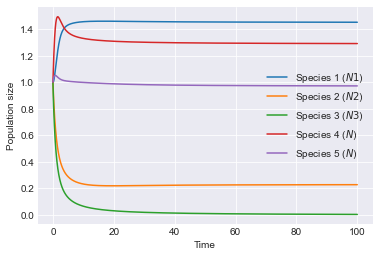

In [16]:
#parameters
t_vec = np.arange(0, 100., 0.01)
Species = 5 #number of species in the system
r_m = np.ones(Species) #max growth rate of each species
a = (random.rand(Species,Species)-0.5) #competition matrix
for i in range(5):
    a[i][i] = -1 #Diagonals = -1 (Carrying Capacity)

#initial condition
N10N20 = np.ones(Species)

#model and solution
def LV(N1N2, t, r_m2, a):
    dN_dt = np.empty(Species)
    for i in range(Species):
        dN_dt[i] = N1N2[i]*r_m[i]*(1 + sumf(a, N1N2, i))
    return dN_dt

N1N2_vec = integrate.odeint(LV, N10N20, t_vec, (r_m, a))

print(a)
#plot
p.style.use('seaborn-darkgrid')
p.plot(t_vec, N1N2_vec)
p.xlabel('Time')
p.ylabel('Population size')
p.legend(['Species 1 ($N1$)', 'Species 2 ($N2$)', 'Species 3 ($N3$)', 'Species 4 ($N$)', 'Species 5 ($N$)'], loc='best')

### Temperature-corrected Lotka-Volterra model with mass scaling

$\frac{dN}{dt} = N_{i}(Y_{0}m_{i}^{\alpha}e^{\frac{-E}{kT}} + \sum \limits _{j}a_{ij}(m_{i},T)N_{j})$<br>

Parameter|Dimension|Possible Values
-----|-----|----- 
$N$|$M$|-
$m$|$M$|~$10^{-12}$ g
$\alpha$|-|$-0.25$
$Y_{0}$|$(TM)^{-1}$|$10^{-6}$ to $1$ ?
$e^{\frac{-E}{kT}}$|-|-
$a_{ij}(m_{i},T)$|$M^{-1}$|$10^{-3}$ to $10^{3}$